# Classification on `emnist`

## 1. Create `Readme.md` to document your work

Explain your choices, process, and outcomes.

## 2. Classify all symbols

### Choose a model

Your choice of model! Choose wisely...

### Train away!

Is do you need to tune any parameters? Is the model expecting data in a different format?

### Evaluate the model

Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets

On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

## 2. Classify digits vs. letters model showdown

Perform a full showdown classifying digits vs letters:

1. Create a column for whether each row is a digit or a letter
2. Choose an evaluation metric 
3. Choose several candidate models to train
4. Divide data to reserve a validation set that will NOT be used in training/testing
5. K-fold train/test
    1. Create train/test splits from the non-validation dataset 
    2. Train each candidate model (best practice: use the same split for all models)
    3. Apply the model the the test split 
    4. (*Optional*) Perform hyper-parametric search
    5. Record the model evaluation metrics
    6. Repeat with a new train/test split
6. Promote winner, apply model to validation set
7. (*Optional*) Perform hyper-parametric search, if applicable
8. Report model performance

# Classification on `emnist`

## 1. Create `Readme.md` to document your work

Explain your choices, process, and outcomes.

## 2. Classify all symbols

### Choose a model

Your choice of model! Choose wisely...

### Train away!

Is do you need to tune any parameters? Is the model expecting data in a different format?

### Evaluate the model

Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets

On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

## 2. Classify digits vs. letters model showdown

Perform a full showdown classifying digits vs letters:

1. Create a column for whether each row is a digit or a letter
2. Choose an evaluation metric 
3. Choose several candidate models to train
4. Divide data to reserve a validation set that will NOT be used in training/testing
5. K-fold train/test
    1. Create train/test splits from the non-validation dataset 
    2. Train each candidate model (best practice: use the same split for all models)
    3. Apply the model the the test split 
    4. (*Optional*) Perform hyper-parametric search
    5. Record the model evaluation metrics
    6. Repeat with a new train/test split
6. Promote winner, apply model to validation set
7. (*Optional*) Perform hyper-parametric search, if applicable
8. Report model performance

### Packages

In [ ]:
# Install required packages (once per virtual environment)
# %pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow xgboost
# %pip install -q emnist
# %reset -f

In [ ]:
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist
from IPython.display import display, Markdown


# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Constants
SIZE = 28
REBUILD = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # or 3 to suppress all warnings

2024-02-11 23:39:52.909634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Helper Functions

In [ ]:
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for a model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['actual letter', 'actual number'], columns=['predicted letter', 'predicted number'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)

### Load Data

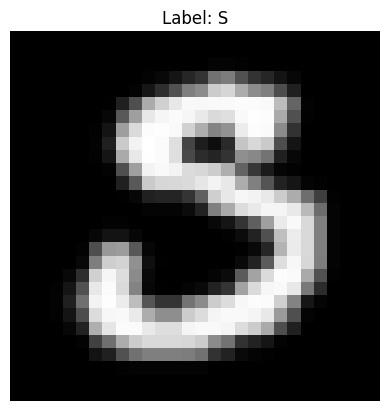

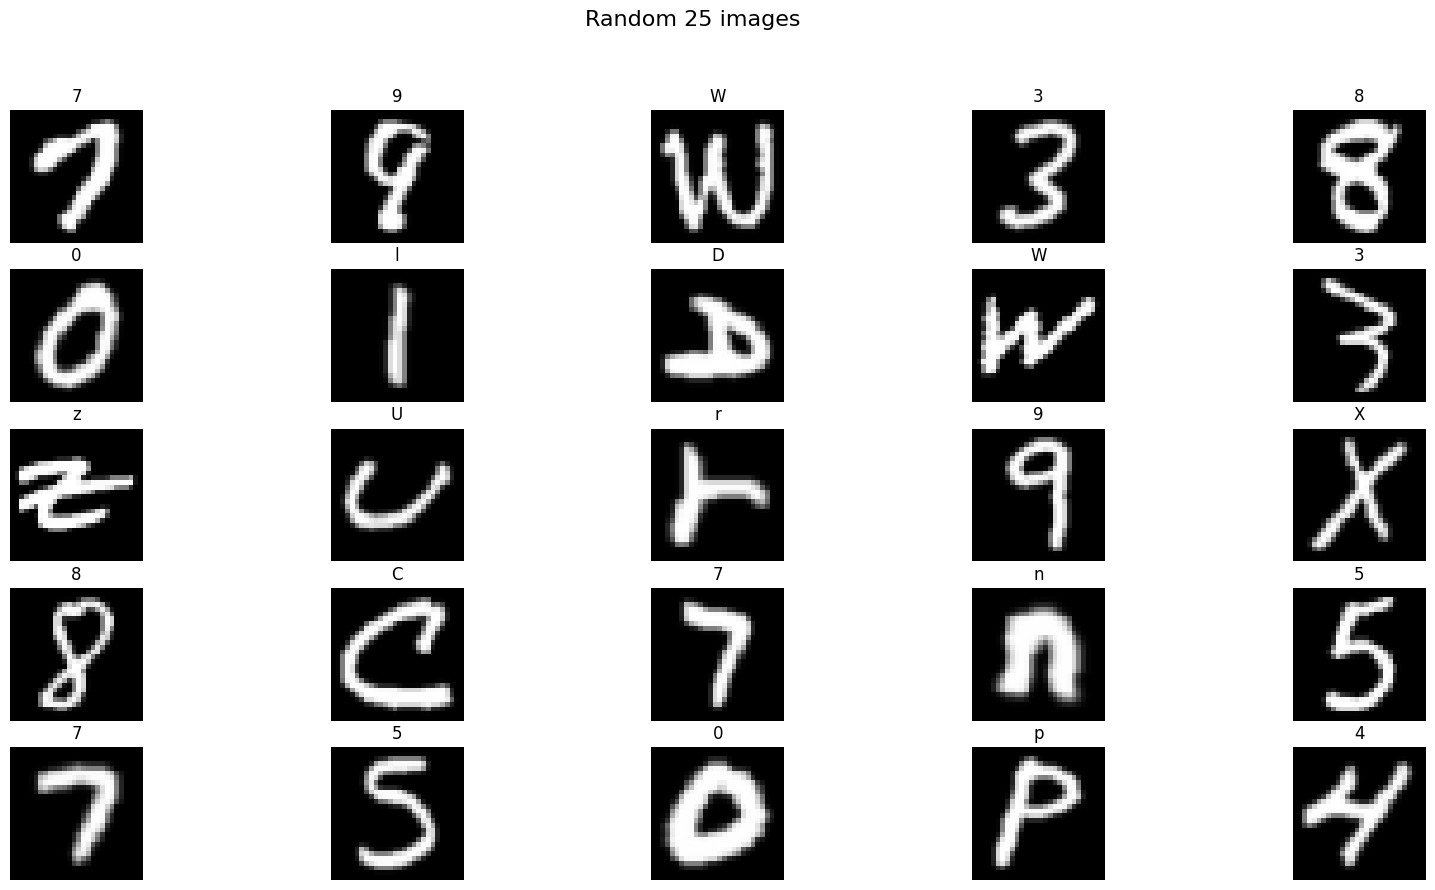

In [ ]:
# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
train['image'] = list(image)
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
valid = pd.DataFrame()
valid['image'] = list(image)
valid['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1))
valid['label'] = label
valid['class'] = class_label


# Using the helper functions

# Plot a random image from the training set
index = np.random.randint(0, len(train))
show_image(train.iloc[index])

# Show a random set of 25 images in a 5x5 grid
show_grid(train.sample(25), title='Random 25 images')

# Show the first 25 images in a 5x5 grid
# show_grid(train[:25], title='First 25 images')

### Subset and Process Data

In [ ]:
# Sample 10% of the original `train` and `valid` data for training speed
train_sampled = train.sample(frac=0.1, random_state=1)  # Use random_state for reproducibility
train_sampled.reset_index(drop=True, inplace=True)

valid_sampled = valid.sample(frac=0.1, random_state=1)  # Use random_state for reproducibility
valid_sampled.reset_index(drop=True, inplace=True)

# Convert labels to 'letter' or 'number'
train_sampled['label_letter_number'] = train_sampled['label'].apply(lambda x: 'letter' if x > 9 else 'number')
valid_sampled['label_letter_number'] = valid_sampled['label'].apply(lambda x: 'letter' if x > 9 else 'number')

# Create a dictionary for performance metrics
metrics_dict = {}

# Show grid of the first 25 images from the sampled training set
# (Ensure the function `show_grid` can handle showing images from the `train_sampled` DataFrame)
# show_grid(train_sampled[:25], title="First 25 images from sampled data")

In [ ]:
metrics_dict = {
    'letter_vs_number' : { 
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

### Random Forest

In [ ]:
# Update task and model information
task = 'letter_vs_number'
model_name = 'random_forest'
metrics_dict[task] = {model_name: {}}

# Initialize random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Prepare the data (assuming 'image_flat' contains the flattened image data)
X_train = np.array(train_sampled['image_flat'].tolist())
y_train = train_sampled['label_letter_number']
X_valid = np.array(valid_sampled['image_flat'].tolist())
y_valid = valid_sampled['label_letter_number']

# Train the model
rf_clf.fit(X_train, y_train)

# Predict on validation set
y_pred = rf_clf.predict(X_valid)

# Calculate performance metrics (Note: Adjusted for binary classification with string labels)
acc = accuracy_score(y_valid, y_pred)
prec = precision_score(y_valid, y_pred, pos_label='number')  
rec = recall_score(y_valid, y_pred, pos_label='number')
f1 = f1_score(y_valid, y_pred, pos_label='number')
cm = confusion_matrix(y_valid, y_pred, labels=['number', 'letter'])  # Explicitly define the order of classes

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: random_forest

,accuracy,precision,recall,f1
0,0.872765,0.865595,0.87943,0.872458


# Confusion Matrix: random_forest

,predicted letter,predicted number
actual letter,5062,694
actual number,786,5090


### Logistic Regression

In [ ]:
# Update task and model information
task = 'letter_vs_number'
model_name = 'logistic_regression'

# Scale the data
scaler = StandardScaler()
# Flatten the images and scale the data
X_train_scaled = scaler.fit_transform(np.array(train_sampled['image_flat'].tolist()))
X_valid_scaled = scaler.transform(np.array(valid_sampled['image_flat'].tolist()))

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Train the logistic regression model using the new labels
lr_clf.fit(X_train_scaled, train_sampled['label_letter_number'])

# Predict on the validation set
y_pred = lr_clf.predict(X_valid_scaled)

# Calculate performance metrics
# Note: Since we are now dealing with string labels ('letter', 'number'), update metric calculations accordingly.
acc = accuracy_score(valid_sampled['label_letter_number'], y_pred)
# For binary classification, specify the positive label explicitly if needed
prec = precision_score(valid_sampled['label_letter_number'], y_pred, pos_label='number')
rec = recall_score(valid_sampled['label_letter_number'], y_pred, pos_label='number')
f1 = f1_score(valid_sampled['label_letter_number'], y_pred, pos_label='number')
cm = confusion_matrix(valid_sampled['label_letter_number'], y_pred, labels=['number', 'letter'])

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1,
    'confusion_matrix': cm
}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: logistic_regression

,accuracy,precision,recall,f1
0,0.737792,0.726861,0.753127,0.739761


# Confusion Matrix: logistic_regression

,predicted letter,predicted number
actual letter,4335,1421
actual number,1629,4247


### XGBoost

In [ ]:
# Update task and model information for letter vs. number classification
task = 'letter_vs_number'
model_name = 'xgboost'

# Initialize XGBoost classifier with specified random state for reproducibility
xgb_clf = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model on the sampled training set
# Note: XGBoost expects numerical labels for classification, so we convert 'number' to 0 and 'letter' to 1
y_train = train_sampled['label_letter_number'].map({'number': 0, 'letter': 1})
y_valid = valid_sampled['label_letter_number'].map({'number': 0, 'letter': 1})

xgb_clf.fit(np.array(train_sampled['image_flat'].tolist()), y_train)

# Predict on the sampled validation set
y_pred = xgb_clf.predict(np.array(valid_sampled['image_flat'].tolist()))

# Calculate performance metrics
# Note: The labels are numeric here, so we use them directly without specifying pos_label
acc = accuracy_score(y_valid, y_pred)
prec = precision_score(y_valid, y_pred)
rec = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
cm = confusion_matrix(y_valid, y_pred)

# Store performance metrics in the dictionary
metrics_dict[task][model_name] = {
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1,
    'confusion_matrix': cm
}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: xgboost

,accuracy,precision,recall,f1
0,0.864856,0.870141,0.86096,0.865526


# Confusion Matrix: xgboost

,predicted letter,predicted number
actual letter,5001,755
actual number,817,5059


### Neural Network

Epoch 1/10
2182/2182 [==============================] - 6s 2ms/step - loss: 0.3820 - accuracy: 0.8217 - val_loss: 0.3432 - val_accuracy: 0.8468
Epoch 2/10
2182/2182 [==============================] - 6s 3ms/step - loss: 0.3005 - accuracy: 0.8652 - val_loss: 0.3001 - val_accuracy: 0.8680
Epoch 3/10
2182/2182 [==============================] - 5s 2ms/step - loss: 0.2709 - accuracy: 0.8797 - val_loss: 0.2842 - val_accuracy: 0.8725
Epoch 4/10
2182/2182 [==============================] - 5s 2ms/step - loss: 0.2518 - accuracy: 0.8889 - val_loss: 0.2814 - val_accuracy: 0.8734
Epoch 5/10
2182/2182 [==============================] - 5s 2ms/step - loss: 0.2376 - accuracy: 0.8950 - val_loss: 0.2738 - val_accuracy: 0.8802
Epoch 6/10
2182/2182 [==============================] - 6s 3ms/step - loss: 0.2291 - accuracy: 0.8975 - val_loss: 0.2813 - val_accuracy: 0.8792
Epoch 7/10
2182/2182 [==============================] - 5s 2ms/step - loss: 0.2187 - accuracy: 0.9027 - val_loss: 0.2718 - val_accuracy:

# Performance Metrics: neural_network

,accuracy,precision,recall,f1
0,0.880588,0.899982,0.859088,0.87906


# Confusion Matrix: neural_network

,predicted letter,predicted number
actual letter,5195,561
actual number,828,5048


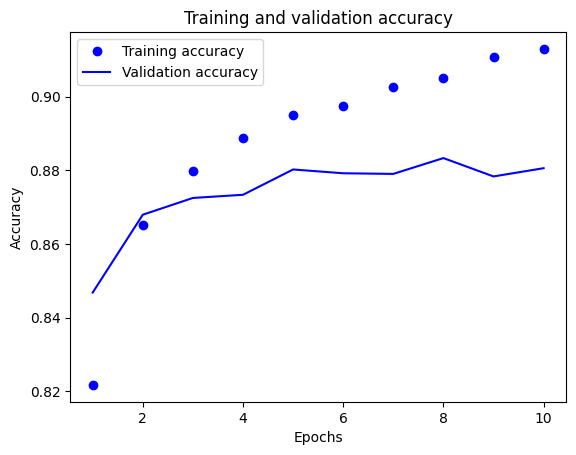

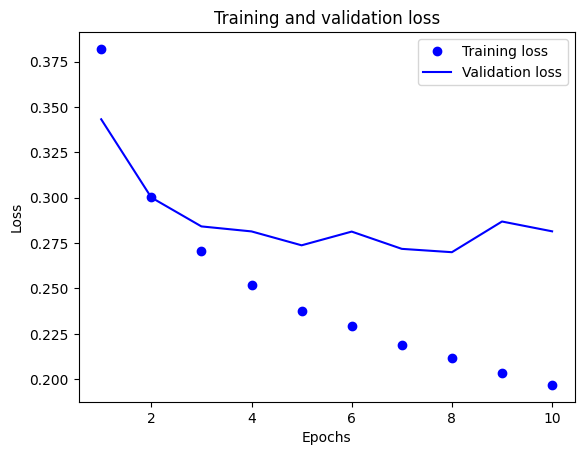

In [ ]:
# Update task and model information for letter vs. number classification
task = 'letter_vs_number'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

# Assuming train_sampled and valid_sampled have been created and include the necessary data
# Convert train images to tensor and normalize
train_images = np.array(train_sampled['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images))) / 255.0

# Prepare train labels for binary classification ('number' as 0 and 'letter' as 1)
train_labels = np.array(train_sampled['label_letter_number'].map({'number': 0, 'letter': 1}))

# Convert validation images to tensor and normalize
valid_images = np.array(valid_sampled['image'])
valid_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images))) / 255.0

# Prepare validation labels for binary classification ('number' as 0 and 'letter' as 1)
valid_labels = np.array(valid_sampled['label_letter_number'].map({'number': 0, 'letter': 1}))


# Initialize neural network model
model = Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Suitable for binary classification
])

# Compile the model for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels))

# Evaluate the model
loss, acc = model.evaluate(valid_images, valid_labels)
y_pred = (model.predict(valid_images) > 0.5).astype(int).flatten()

# Calculate performance metrics
prec = precision_score(valid_labels, y_pred)
rec = recall_score(valid_labels, y_pred)
f1 = f1_score(valid_labels, y_pred)
cm = confusion_matrix(valid_labels, y_pred)

# Store performance metrics in the dictionary
metrics_dict[task][model_name] = {
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1,
    'confusion_matrix': cm
}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Assuming plot_accuracy and plot_loss are functions that plot the training history
plot_accuracy(history)
plot_loss(history)

### Model Comparison

In [ ]:
# create an empty DataFrame to hold the results
results_df = pd.DataFrame()

# iterate over the keys in the metrics_dict
for key in metrics_dict:
    
    # create a new DataFrame to hold the results for this key
    df = pd.DataFrame.from_dict(metrics_dict[key], orient='index')
    
    # add a new row to the DataFrame indicating the model name and metric type
    df = df.assign(model=key, metric=df.index)
    
    # set the index to the 'model' and 'metric' columns
    df = df.set_index(['model', 'metric'])
    
    # append the results to the main DataFrame
    results_df = pd.concat([results_df, df])

# display the resulting table
display(results_df)

accuracy  precision    recall        f1  \
model            metric                                                         
letter_vs_number random_forest        0.872765   0.865595  0.879430  0.872458   
                 logistic_regression  0.737792   0.726861  0.753127  0.739761   
                 xgboost              0.864856   0.870141  0.860960  0.865526   
                 neural_network       0.880588   0.899982  0.859088  0.879060   

                                                  confusion_matrix  
model            metric                                             
letter_vs_number random_forest          [[5062, 694], [786, 5090]]  
                 logistic_regression  [[4335, 1421], [1629, 4247]]  
                 xgboost                [[5001, 755], [817, 5059]]  
                 neural_network         [[5195, 561], [828, 5048]]